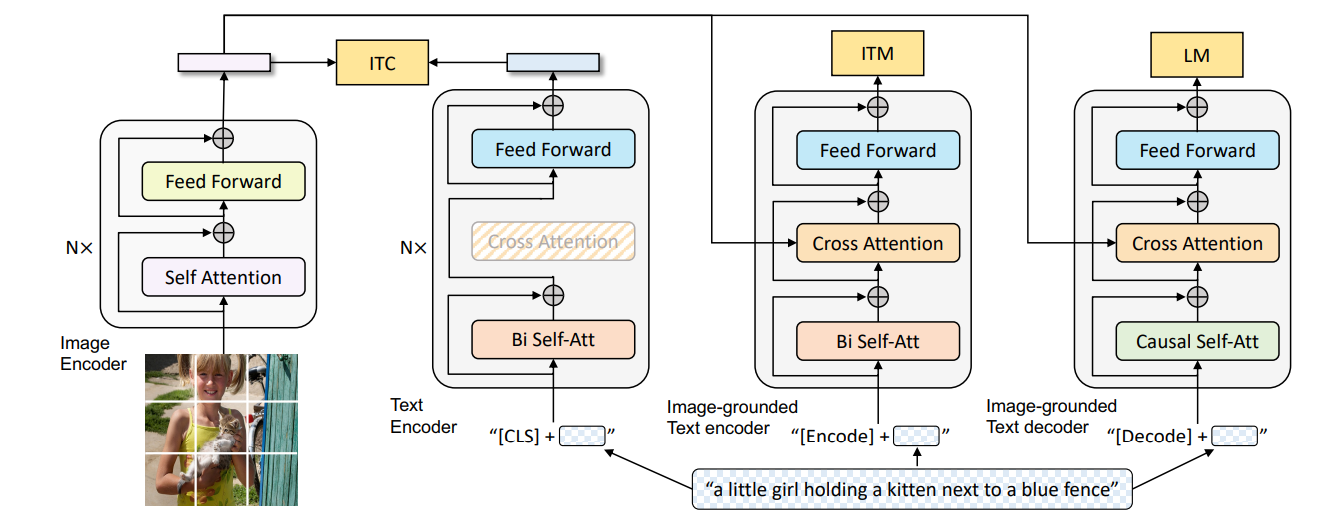

# BLIP: Inference Demo
 - [Image Captioning](#Image-Captioning)
 - [VQA](#VQA)
 - [Feature Extraction](#Feature-Extraction)
 - [Image Text Matching](#Image-Text-Matching)
 - [Natural Language Visual Reasoning](#Natural-Language-Visual-Reasoning)

In [ ]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP

Running in Colab.
fatal: destination path 'BLIP' already exists and is not an empty directory.
/content/BLIP


In [ ]:
!pip install timm fairscale transformers

In [ ]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_demo_image(image_size,device):
    img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))

    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
    image = transform(raw_image).unsqueeze(0).to(device)
    return image

In [ ]:
def load_image_from_file(image_path,image_size,device):
    raw_image = Image.open(image_path).convert('RGB')

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))

    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
    image = transform(raw_image).unsqueeze(0).to(device)
    return image


def load_image_from_url(img_url,image_size,device):
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))

    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
    image = transform(raw_image).unsqueeze(0).to(device)
    return image

# Image Captioning
Perform image captioning using finetuned BLIP model

In [ ]:
%load_ext autoreload
%autoreload 2

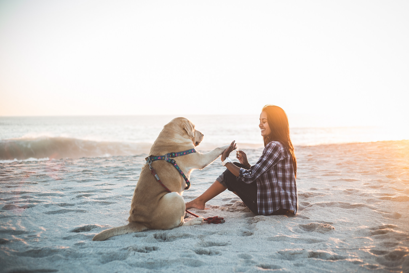

In [ ]:
image_size = 384
image_demo = load_demo_image(image_size=image_size, device=device)

In [ ]:
from models.blip import blip_decoder

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'

model_captioner = blip_decoder(pretrained=model_url, image_size=image_size, vit='base', prompt = 'a picture of ')
model_captioner.eval()
model_captioner = model_captioner.to(device)

In [ ]:
def image_captioning(model_captioner, image):
  with torch.no_grad():
      # beam search
      # caption = model_captioner.generate(image, sample=False, num_beams=3, max_length=20, min_length=5)
      # does not work because of query key dims non compatabilities
      # nucleus sampling
      caption = model_captioner.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5)
  return 'caption: '+caption[0]

In [ ]:
image_captioning(model_captioner, image_demo)

'caption: a dog on the beach in the sand'

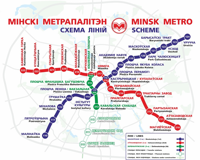

In [ ]:
minsk_metro = load_image_from_url('http://gusts.minsk.by/upload/medialibrary/a87/a87b098766d90179d8ba9eeba86ab8b6.jpg',image_size=image_size, device=device)

In [ ]:
image_captioning(model_captioner, minsk_metro)

'caption: the metro map for moscow'

In [ ]:
from models.blip import blip_decoder

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'

model_counter = blip_decoder(pretrained=model_url, image_size=image_size, vit='base', prompt='how many')
model_counter.eval()
model_counter = model_counter.to(device)

100%|██████████| 1.97G/1.97G [00:27<00:00, 76.3MB/s]


reshape position embedding from 196 to 900
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth


In [ ]:
image_captioning(model_counter, image_demo)

'caption:  young women should choose between being pets and dog lovers'

In [ ]:
image_captioning(model_counter, image_demo)

'caption:  people are concerned about pet beaches'

# VQA
Perform visual question answering using finetuned BLIP model

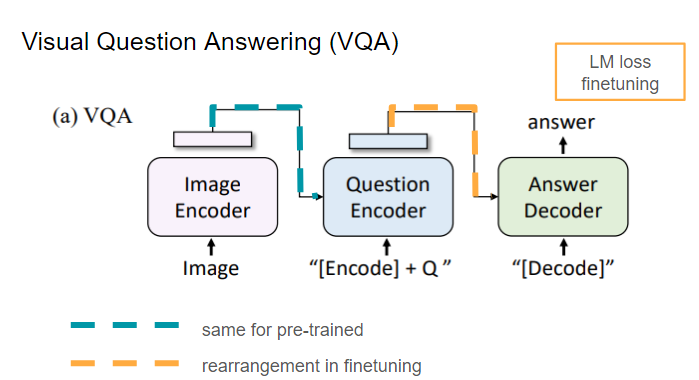

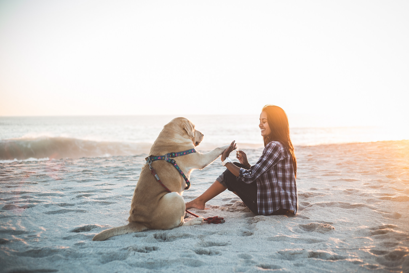

In [ ]:
image_size = 480
image_demo = load_demo_image(image_size=image_size, device=device)

In [ ]:
from models.blip_vqa import blip_vqa

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth'

model_vqa = blip_vqa(pretrained=model_url, image_size=image_size, vit='base')
model_vqa.eval()
model_vqa = model_vqa.to(device)


load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth


In [ ]:
# in /content/BLIP/models/blip_vqa.py the same problem with attention for beams => num_beams = 1

In [ ]:
def vqa(model_vqa, image, question):
  with torch.no_grad():
      answer = model_vqa(image, question, train=False, inference='generate')
  return 'answer: '+answer[0]

In [ ]:
question = 'where is the woman sitting?'

vqa(model_vqa, image_demo, question)

'answer: on beach'

In [ ]:
question = 'how much does the shirt cost?'

vqa(model_vqa, image_demo, question)

'answer: $ 20'

In [ ]:
question = 'how much does the dog cost?'

vqa(model_vqa, image_demo, question)

'answer: free'

In [ ]:
question = 'what breed is the dog?'

vqa(model_vqa, image_demo, question)

'answer: lab'

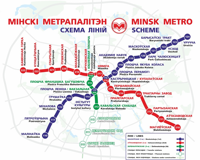

In [ ]:
image_size = 480
minsk_metro = load_image_from_url('http://gusts.minsk.by/upload/medialibrary/a87/a87b098766d90179d8ba9eeba86ab8b6.jpg',image_size=image_size, device=device)

In [ ]:
question = 'what city is this?'

vqa(model_vqa, image=minsk_metro, question=question)

'answer: china'

In [ ]:
question = 'how many metro branches on the scheme?'

vqa(model_vqa, image=minsk_metro, question=question)

'answer: 12'

# Feature Extraction

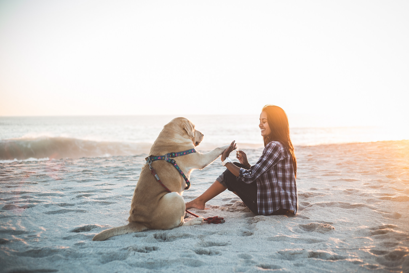

100%|██████████| 1.97G/1.97G [00:25<00:00, 82.4MB/s]


load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth


In [ ]:
from models.blip import blip_feature_extractor

image_size = 224
image = load_demo_image(image_size=image_size, device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth'

model = blip_feature_extractor(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

caption = 'a woman sitting on the beach with a dog'

multimodal_feature = model(image, caption, mode='multimodal')[0,0]
image_feature = model(image, caption, mode='image')[0,0]
text_feature = model(image, caption, mode='text')[0,0]

# Image-Text Matching

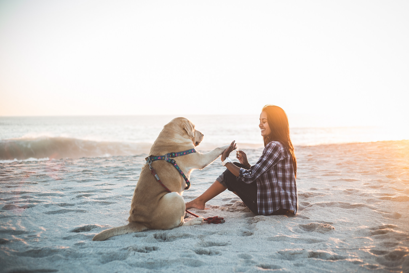

In [ ]:
image_size = 384
image_demo = load_demo_image(image_size=image_size,device=device)

In [ ]:
from models.blip_itm import blip_itm

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'

model_itm = blip_itm(pretrained=model_url, image_size=image_size, vit='base')
model_itm.eval()
model_itm = model_itm.to(device=device)

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth


In [ ]:
def itm(model_itm, image, caption):
  itm_output = model_itm(image,caption,match_head='itm')
  itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
  itc_score = model_itm(image,caption,match_head='itc')

  return 'The image and text is matched with a probability of %.4f'%itm_score, 'The image feature and text feature has a cosine similarity of %.4f'%itc_score

In [ ]:
caption = 'a woman sitting on the beach with a dog'

itm(model_itm, image_demo, caption)

('The image and text is matched with a probability of 0.9960',
 'The image feature and text feature has a cosine similarity of 0.5262')

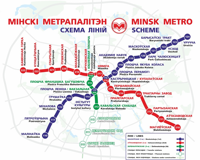

In [ ]:
image_size = 384
minsk_metro = load_image_from_url('http://gusts.minsk.by/upload/medialibrary/a87/a87b098766d90179d8ba9eeba86ab8b6.jpg',image_size=image_size, device=device)

In [ ]:
caption = 'Minsk metro scheme'

itm(model_itm, minsk_metro, caption)

('The image and text is matched with a probability of 1.0000',
 'The image feature and text feature has a cosine similarity of 0.4758')

In [ ]:
caption = 'Moscow metro scheme'

itm(model_itm, minsk_metro, caption)

('The image and text is matched with a probability of 0.9998',
 'The image feature and text feature has a cosine similarity of 0.4598')

In [ ]:
caption = 'Paris metro scheme'

itm(model_itm, minsk_metro, caption)

('The image and text is matched with a probability of 0.7747',
 'The image feature and text feature has a cosine similarity of 0.3736')

# Natural Language Visual Reasoning

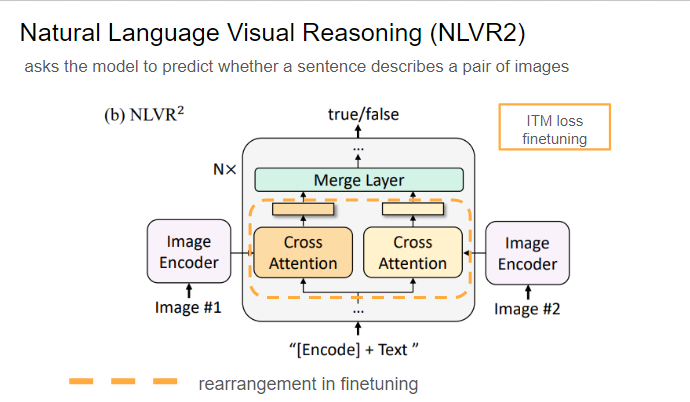

In [ ]:
from models.blip_nlvr import blip_nlvr
image_size = 480
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_nlvr.pth'

model_nlvr = blip_nlvr(pretrained=model_url, image_size=image_size, vit='base')
model_nlvr.eval()
model_nlvr = model_nlvr.to(device)


reshape position embedding from 576 to 900
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_nlvr.pth
missing keys:
[]


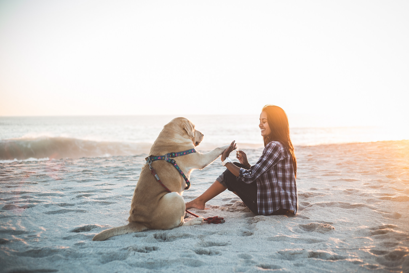

In [ ]:
image_size = 480
image_demo = load_demo_image(image_size=image_size,device=device)

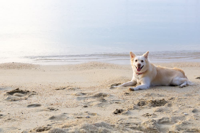

In [ ]:
image_size = 480
dog_beach = load_image_from_url('https://cdn-prd.content.metamorphosis.com/wp-content/uploads/sites/6/2022/01/shutterstock_1374545387-1.jpg',image_size=image_size, device=device)


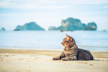

In [ ]:
image_size = 480
cat_beach = load_image_from_url('https://t3.ftcdn.net/jpg/02/03/26/82/360_F_203268202_Wxy51M8jTy6S4JfGQ1czZNedBrROn95A.jpg', image_size=image_size, device=device)

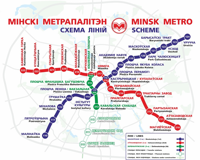

In [ ]:
image_size = 480
minsk_metro = load_image_from_url('http://gusts.minsk.by/upload/medialibrary/a87/a87b098766d90179d8ba9eeba86ab8b6.jpg',image_size=image_size, device=device)

In [ ]:
images = torch.cat([image_demo, dog_beach], dim=0)

prediction = model_nlvr(images, text="dog on the beach", targets=torch.tensor([[1,1]]), train=False)
prediction.max(1)

torch.return_types.max(
values=tensor([3.2843], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0'))

In [ ]:
images = torch.cat([cat_beach, minsk_metro], dim=0)

prediction = model_nlvr(images, text="dog and the woman", targets=torch.tensor([[0,0]]), train=False)
prediction.max(1)

torch.return_types.max(
values=tensor([2.7341], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0], device='cuda:0'))

In [ ]:
images = torch.cat([minsk_metro, cat_beach], dim=0)

prediction = model_nlvr(images, text="dog and the woman", targets=torch.tensor([[0,0]]), train=False)
prediction.max(1)

torch.return_types.max(
values=tensor([2.9689], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0], device='cuda:0'))

In [ ]:
images = torch.cat([dog_beach, cat_beach], dim=0)

prediction = model_nlvr(images, text="dog on the beach", targets=torch.tensor([[0,0]]), train=False)
prediction.max(1)

torch.return_types.max(
values=tensor([3.2911], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1], device='cuda:0'))

# Zero-shot Transfer to Video-Language Tasks

In [ ]:
!wget -nc https://download2390.mediafire.com/21a2eehe09cgvJVrJ55C-gK6S3PIOKh1JKzSUvgmncihze9VCIkyA7QYc_w79ohqX4Hzpag-vOPn_lAr5i89dVwL5cxy25PwVB82KGUQW56k5PFO8gON1DwmGXp_YjJ6biFYhyYt0YorZT_c_ttf2dWCRzyXEjomCSno6NWKc40HNozJ/czh8sezbo9s4692/test_videos.zip

In [ ]:
!pip install decord

In [ ]:
!unzip test_videos.zip

In [ ]:
!pip install pycocoevalcap

In [ ]:
!python -m torch.distributed.run --nproc_per_node=8 eval_retrieval_video.py